In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tqdm.auto import tqdm

sns.set_style('darkgrid')

In [2]:
train = pd.read_csv('./plant-pathology-2021-fgvc8/train.csv')
print(train.shape)
train.head()

(18632, 2)


,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex


<AxesSubplot:title={'center':'Target Class Distribution'}>

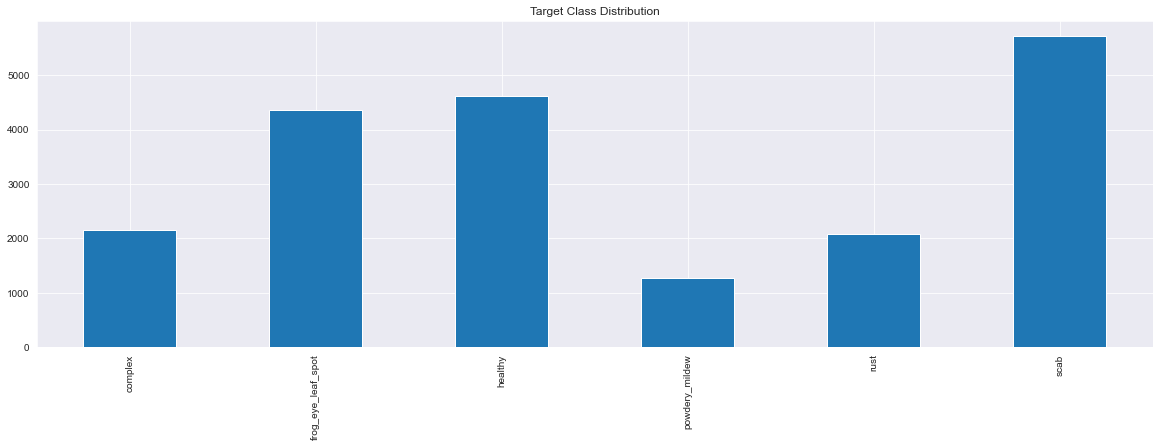

In [4]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer().fit(train.labels.apply(lambda x: x.split()))
labels = pd.DataFrame(mlb.transform(train.labels.apply(lambda x: x.split())), columns=mlb.classes_)

fig, ax = plt.subplots(figsize=(20, 6))
labels.sum().plot.bar(title='Target Class Distribution')

<AxesSubplot:title={'center':'Distribution of Number of Labels per Image'}>

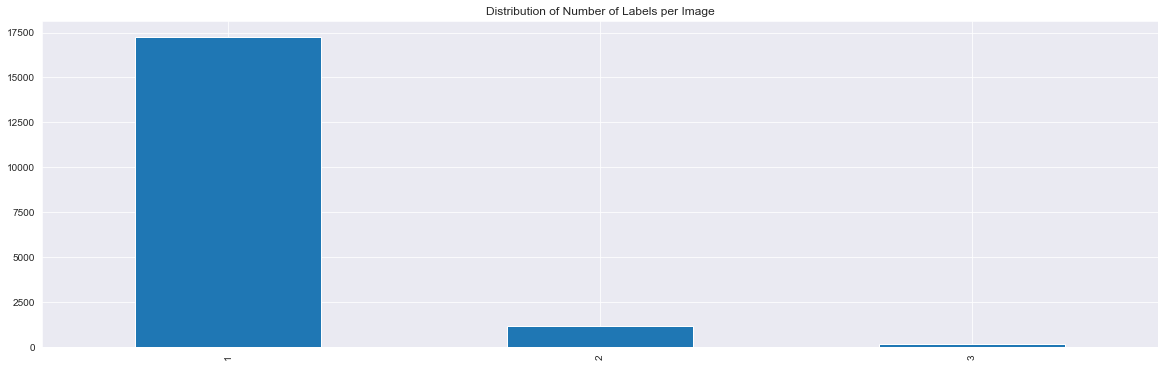

In [6]:
fig, ax = plt.subplots(figsize=(20, 6))
labels.sum(axis=1).value_counts().plot.bar(title='Distribution of Number of Labels per Image')

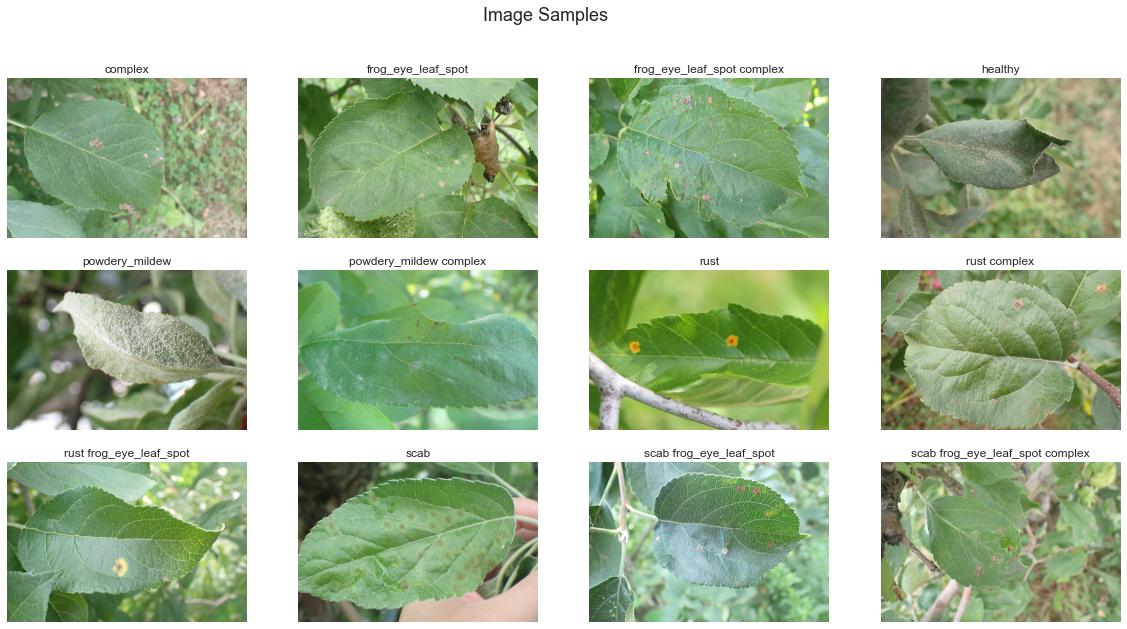

In [7]:
fig, ax = plt.subplots(3, 4, figsize=(20, 10))
for i, img in enumerate(train.groupby('labels').first().reset_index().values):
    ax[i//4][i%4].imshow(plt.imread(f"./plant-pathology-2021-fgvc8/train_images/{img[1]}"))
    ax[i//4][i%4].set_title(img[0])
    ax[i//4][i%4].axis('off')
fig.suptitle('Image Samples', fontsize=18); 

In [8]:
# Preprocessing and Augmentation
labels = pd.concat([train['image'], labels], axis=1)
labels.head()

,image,complex,frog_eye_leaf_spot,healthy,powdery_mildew,rust,scab
0,800113bb65efe69e.jpg,0,0,1,0,0,0
1,8002cb321f8bfcdf.jpg,1,1,0,0,0,1
2,80070f7fb5e2ccaa.jpg,0,0,0,0,0,1
3,80077517781fb94f.jpg,0,0,0,0,0,1
4,800cbf0ff87721f8.jpg,1,0,0,0,0,0


In [11]:
image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.1)

train_generator = image_data_generator.flow_from_dataframe(
    dataframe=labels,
    directory='./plant-pathology-2021-fgvc8/train_images',
    x_col='image',
    y_col=labels.columns.tolist()[1:],
    class_mode='raw',
    color_mode="rgb",
    target_size=(224, 224),
    batch_size=64,
    subset='training'
)

valid_generator = image_data_generator.flow_from_dataframe(
    dataframe=labels,
    directory='./plant-pathology-2021-fgvc8/train_images',
    x_col='image',
    y_col=labels.columns.tolist()[1:],
    class_mode='raw',
    color_mode="rgb",
    target_size=(224, 224),
    batch_size=64,
    subset='validation'
)

Found 16769 validated image filenames.
Found 1863 validated image filenames.


In [16]:
#Modeling
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.applications.MobileNetV2(include_top=False)(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(6, activation='sigmoid')(x)

model = tf.keras.models.Model(inputs, outputs)
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=1e-4))

model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, None, None, 1280)  2257984   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 7686      
Total params: 2,265,670
Trainable params: 2,231,558
Non-trainable params: 34,112
_________________________________________________________________
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [17]:
rlp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.01)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

history = model.fit(train_generator, validation_data=valid_generator, epochs=10, callbacks=[rlp, es])